# Automatic image classification (SIFT extraction and Bag of Words)
Pierre-Yves BOISBUNON - April 2018

----------

In this notebook, we will classify our previously prepared images (see **notebook_prepare_train_and_test.ipynb**) based on a classific approch:
- Filtering
- Feature extraction (using SIFT)
- Clustering
- Histogram build
- Classification

In [1]:
from PIL import Image
import numpy as np
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from __future__ import division
from sklearn.preprocessing import StandardScaler
import os
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
import imutils
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import f1_score

Let's define a random state for future usage:

In [2]:
random_state = 100

# 1. Let's create our first model

Let's define the **filter_image** function to read image and return the grayscale array:

In [3]:
def filter_image(path):
    image = cv2.imread(path)
    # Convert to gray
    image = cv2.cvtColor(np.asarray(image), cv2.COLOR_BGR2GRAY)
    return image

Let's first create SIFT object:

In [4]:
# Create feature extraction and keypoint detector objects
fea_det = cv2.xfeatures2d.SIFT_create()

In [5]:
# Get the training classes names and store them in a list
train_path = 'dataset/train'

Let's define the **read_images** function to read all images from a specific path and return their associated labels (dog breeds):

In [6]:
def read_images(path):
    # Get all the path to the images and save them in a list
    # image_paths and the corresponding label in image_paths
    image_paths = []
    image_classes = []
    folder_names = os.listdir(path)
    class_id = 0
    for folder in folder_names:
        print("Read folder: " + folder)
        dir = os.path.join(path, folder)
        class_path = imutils.imlist(dir)
        image_paths+=class_path
        image_classes+=[class_id]*len(class_path)
        class_id+=1
    return folder_names, image_classes, image_paths

Let's first import train image:

In [7]:
labels, image_classes, image_paths = read_images(train_path)

Read folder: n02086646-Blenheim_spaniel
Read folder: n02088094-Afghan_hound
Read folder: n02093256-Staffordshire_bullterrier
Read folder: n02094114-Norfolk_terrier
Read folder: n02099712-Labrador_retriever


We can also define the function **extract_features** to extract SIFT features from an input image_paths:

In [8]:
def extract_features(image_paths, image_classes):
    # List where all the descriptors are stored
    desc_list = []
    for image_path in image_paths:
        #im = cv2.imread(image_path)
        im = filter_image(image_path)
        kpts, des = fea_det.detectAndCompute(im, None)
        # Catch none descriptor
        if (des is None):
            print("no descriptor found for: " + image_path)
            des = np.array([[0]*128])
        desc_list.append((image_path, des))
    # Stack all the descriptors vertically in a numpy array
    descriptors = desc_list[0][1]
    i = 0
    classes_stack = [image_classes[i]]*len(desc_list[0][1])
    i += 1
    for image_path, descriptor in desc_list[1:]:
        descriptors = np.vstack((descriptors, descriptor))
        classes_stack += [image_classes[i]]*len(descriptor)
        i += 1
    return desc_list, descriptors, classes_stack

We will than have a list of descriptors as output:

In [9]:
desc_list, descriptors, classes_stack = extract_features(image_paths, image_classes)

We can then define the function **plot_descriptors** to display descriptors in 2 dimensions:

In [10]:
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
import matplotlib
def plot_descriptors(descriptors, classes_stack, labels, random_state):
    step = 100
    size = len(descriptors)
    selection = list(range(0, size, step))
    desc_subset = [descriptors[i] for i in selection]
    cl_subset = [classes_stack[i] for i in selection]
    # Build TSNE 
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=random_state)
    X_tsne = tsne.fit_transform(desc_subset)
    x_coords = X_tsne[:, 0]
    y_coords = X_tsne[:, 1]
    # display scatter plot
    colors = ['red','green','blue','purple','yellow']
    plt.scatter(x_coords, y_coords,  c=cl_subset, cmap=matplotlib.colors.ListedColormap(colors))
    cb = plt.colorbar()
    loc = np.arange(0,max(cl_subset),max(cl_subset)/float(len(colors)))
    cb.set_ticks(loc)
    cb.set_ticklabels(labels)

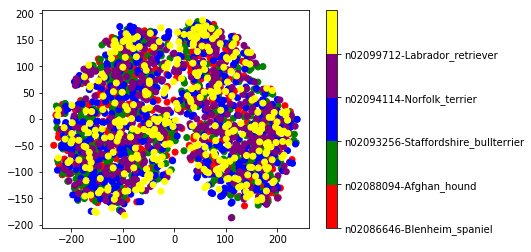

In [11]:
plot_descriptors(descriptors, classes_stack, labels, random_state)

The visualisation of the descriptors in 2 dimensions per breed allow to show:
- all descriptors seems to be melt breed per breeds.

In [29]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
def plot_silhouette(X, random_state):
    range_n_clusters = [20, 50, 70, 100]

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=random_state)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

Let's try to clusterize these descriptors to reduce the amount of features:

For n_clusters = 20 The average silhouette_score is : 0.0546542


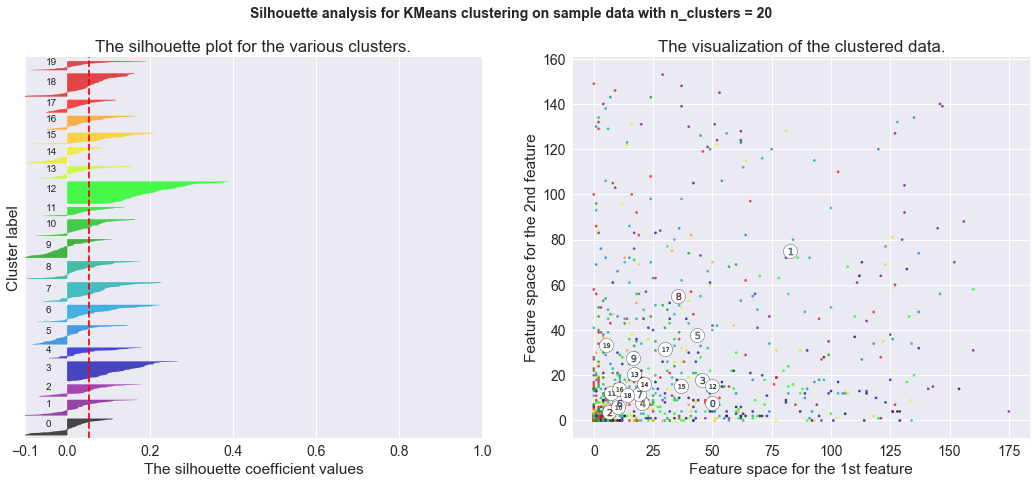

For n_clusters = 50 The average silhouette_score is : 0.0581647


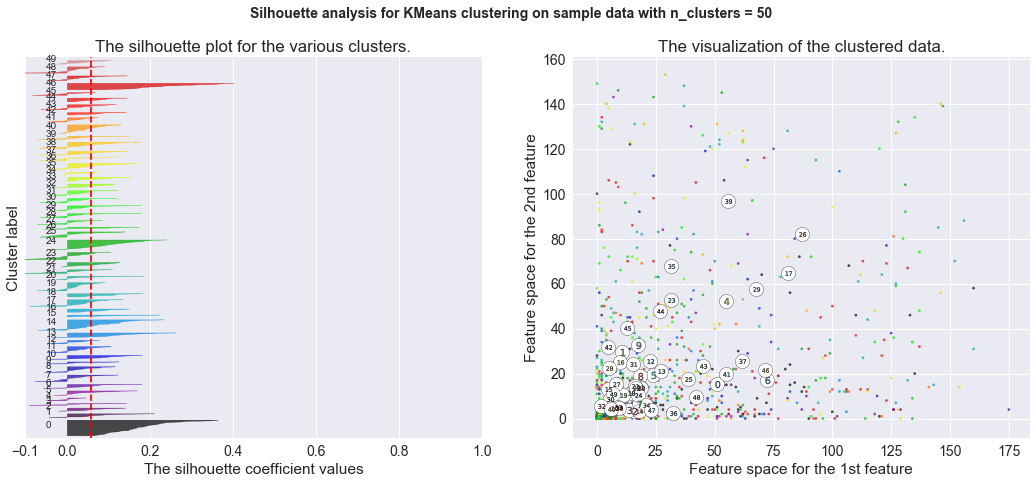

For n_clusters = 70 The average silhouette_score is : 0.0490362


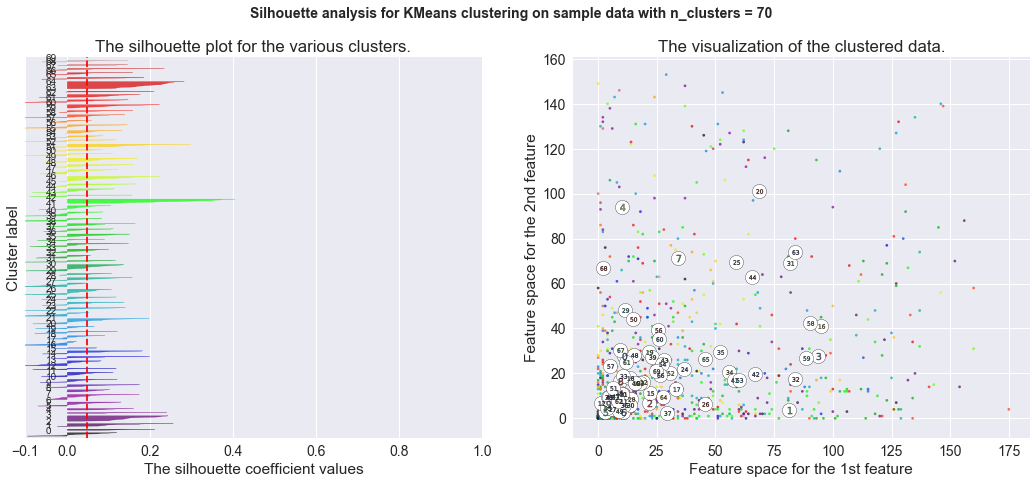

For n_clusters = 100 The average silhouette_score is : 0.0512085


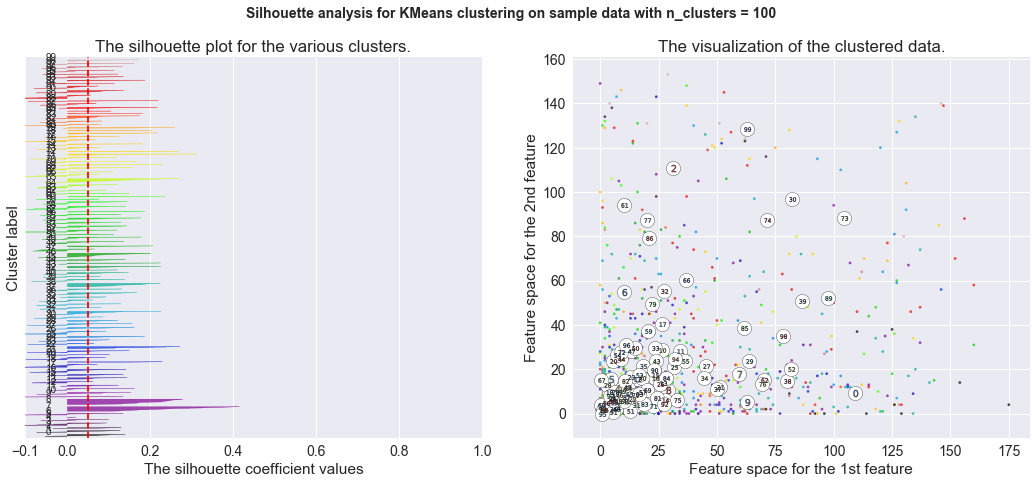

In [109]:
plot_silhouette(descriptors[:1000], random_state)

It seems an amount of **70** clusters is the best score (from elbow method).

In [110]:
def build_vocabulary(n_clusters, random_state, descriptors, des_list, n_images, kmeans_obj=None):
    if kmeans_obj is None:
        kmeans_obj = KMeans(n_clusters = n_clusters, random_state=random_state)
        kmeans_ret = kmeans_obj.fit_predict(descriptors)
    else:
        kmeans_ret = kmeans_obj.predict(descriptors)
    mega_histogram = np.array([np.zeros(n_clusters) for i in range(n_images)])
    old_count = 0
    for i in range(n_images):
        l = len(des_list[i][1])
        for j in range(l):
            idx = kmeans_ret[old_count+j]
            mega_histogram[i][idx] += 1
        old_count += l
    return kmeans_obj, kmeans_ret, mega_histogram

Let's build now the vocabulary from this amount of clusters.

In [111]:
n_clusters=70
kmeans_obj, kmeans_ret,mega_histogram = build_vocabulary(n_clusters, random_state, descriptors, desc_list, len(image_paths))

In [112]:
def plot_vocabulary(n_clusters, n_images, vocab, image_classes):
    f = plt.figure(figsize=(10,10))
    for i in range(5):
        idx = np.where(np.array(image_classes) == i)
        vocab_subset = vocab[idx]
        x_scalar = np.arange(n_clusters)
        y_scalar = np.array([abs(np.sum(vocab_subset[:,h], dtype=np.int32)) for h in range(n_clusters)])
        ax = f.add_subplot(321 + i)
        ax.bar(x_scalar, y_scalar)
        ax.set_title("Class: " + labels[i])
        ax.tick_params(labelsize=6)
        ax.title.set_size(15)
    f.show()

If we plot the vocabulary:
- there is no clear difference between each histogram
- some features looks similare (eg: bulterrier and Labrador)

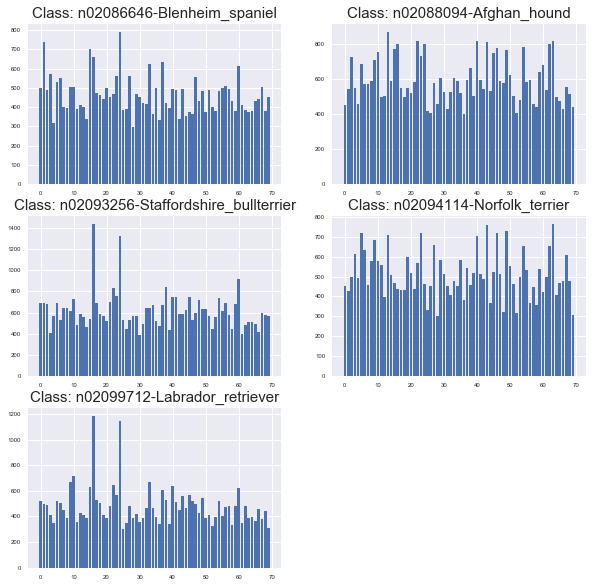

In [113]:
plot_vocabulary(n_clusters, len(image_paths), mega_histogram, image_classes)

In [114]:
def plot_clusters(vocab, classes, labels, random_state):
    step = 1
    size = len(vocab)
    selection = list(range(0, size, step))
    vocab_subset = [vocab[i] for i in selection]
    cl_subset = [classes[i] for i in selection]
    # Build TSNE 
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=random_state)
    X_tsne = tsne.fit_transform(vocab_subset)
    x_coords = X_tsne[:, 0]
    y_coords = X_tsne[:, 1]
    # display scatter plot
    colors = ['red','green','blue','purple','yellow']
    plt.scatter(x_coords, y_coords,  c=cl_subset, cmap=matplotlib.colors.ListedColormap(colors))
    cb = plt.colorbar()
    loc = np.arange(0,max(cl_subset),max(cl_subset)/float(len(colors)))
    cb.set_ticks(loc)
    cb.set_ticklabels(labels)

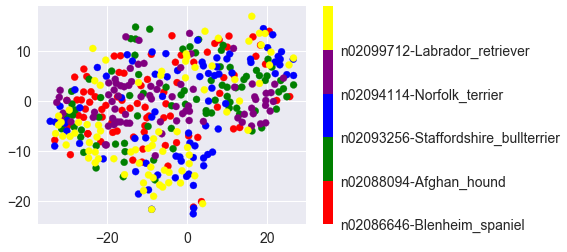

In [115]:
plot_clusters(mega_histogram, image_classes, labels, random_state)

If we display the results of our clusters in 2 dimensions, we can't see clear separation of breeds.

In [116]:
def model_fit(vocab, classes, random_state):
    scale = StandardScaler().fit(vocab)
    vocab = scale.transform(vocab)
    clf = LinearSVC(random_state=random_state)
    clf.fit(vocab, classes)
    return scale, clf

Let's try a first model based on **LinearSVC** estimator:

In [117]:
scale, clf = model_fit(mega_histogram, image_classes, random_state)

## 1.2 Test model

In [118]:
def model_predict(vocab, scale, clf, classes, labels):
    vocab = scale.transform(vocab)
    y_pred = clf.predict(vocab)
    print("f1 score: ", f1_score(classes, y_pred, average='micro'))
    # Plot confusion matrix
    predictions =  [labels[i] for i in y_pred]
    real = [labels[i] for i in classes]
    cm = confusion_matrix(predictions, real)
    df_cm = pd.DataFrame(cm, index = labels,
                      columns = labels)
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})

Let's predict our validation images now:

Read folder: n02086646-Blenheim_spaniel
Read folder: n02088094-Afghan_hound
Read folder: n02093256-Staffordshire_bullterrier
Read folder: n02094114-Norfolk_terrier
Read folder: n02099712-Labrador_retriever
f1 score:  0.45


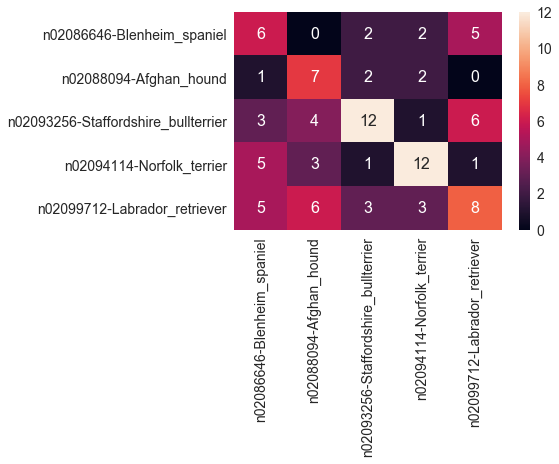

In [119]:
test_path = 'dataset/test'
# Read images
labels, image_classes, image_paths = read_images(test_path)
# Extract features
desc_list, descriptors, classes_stack = extract_features(image_paths, image_classes)
# Build vocabulary
kmeans_obj, kmeans_ret, mega_histogram = build_vocabulary(n_clusters, random_state, descriptors, desc_list, len(image_paths), kmeans_obj)
# Model prediction
model_predict(mega_histogram, scale, clf, image_classes, labels)

We have then a baseline for this classic approach **0.47** with a linear SVC model where we can see that some breeds looks :
- less good predicted than other (Afghan hound vs Norfolk terrier for example).

Let's try to optimize our feature extraction now.
Look following notebook **notebook_bag_of_words_cv.ipynb**